**Горностаев А. ML-11**

In [1]:
# is_drive = True

# def get_path(file_name):
#   drive_path_prefix = "/content/drive/MyDrive/Технопарк 2021 ML/lecture04/"
#   simple_path_prefix ="."
#   if is_drive:
#     return f"{drive_path_prefix}/{file_name}"
#   else:
#     return f"{simple_path_prefix}/{file_name}"
!ls

hw.ipynb


In [2]:
# if is_drive:
#   from google.colab import drive
#   drive.mount('/content/drive')
!ls ./../images

Kmeans_animation.gif    kmeans-guys.jpeg        pca_svd.png
cumul_rat.png           kmeans_2moons.png       plane_best_fit.png
dbscan.png              kmeans_digits.png       rand1.png
dbscan_points_types.png languages.png           rand2.png
diff-dens.png           mainfold.png            sil1.png
digits.png              mds.png                 sil2.png
header.png              mnistdigits.jpg         sphere_example.png
header2.png             pca.png                 t-distr.png
kld.png                 pca_example.png


<center><img src="images/header.png" width=400></center>

<h1><center>Основы машинного обучения</center></h1>
<hr>
<h2><center>Методы обучения без учителя: Домашняя работа</center></h2>

Правила:

* Отчеты принимаются до 23:59 11 апреля. Вы должны залить ваш ноутбук в [colab](https://colab.research.google.com) и дать на него ссылку в форме сдачи ДЗ на портале
* Работоспособность будет проверяться в коллабе. Это значит что:
    1. Вам надо удостовериться, что код отрабатывает от начала и до конца. Выполните аналог "Restart Kernel and Run All" в colab
    2. Убедитесь, что данные автоматически подгружается с помощью команды `!wget` (см семинары для примера). Все нужные данные есть [здесь](https://github.com/vadim0912/MLbase_2021_spring/tree/master/lecture04/data)
    3. Все необходимые модули тоже устанавливаются на лету через `!pip`


In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

# Задача про датчики на руках

В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными [данными](http://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html) являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [3]:
!ls

data     hw.ipynb images


In [4]:
# !wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture04/data/sign_database.csv
# !wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture04/data/sign_classes.csv

In [5]:
# Загружаем данные сенсоров
df_database = pd.read_csv('./../data/sign_database.csv', header=0, index_col=None)

# Загружаем метки классов
sign_classes = pd.read_csv('./../data/sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [6]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

,x_l,x_r,y_l,y_r,z_l,z_r,roll_l,roll_r,pitch_l,pitch_r,...,forefinger_l,forefinger_r,middle_l,middle_r,ring_l,ring_r,little_l,little_r,id,time
0,-0.097816,-0.127761,-0.029051,0.537977,0.249162,0.508908,0.239445,0.039819,0.0,0.007009,...,0.369149,0.381857,0.570995,0.343431,0.0,0.000000,0.0,0.133088,0,0
1,-0.102460,-0.126734,-0.029230,0.537758,0.246477,0.507236,0.240116,0.039057,0.0,0.007009,...,0.326618,0.402561,0.595044,0.291571,0.0,0.000000,0.0,0.084865,0,1
2,-0.103085,-0.125618,-0.028605,0.537464,0.244890,0.507273,0.234753,0.039057,0.0,0.007494,...,0.295135,0.436131,0.639491,0.242470,0.0,0.000000,0.0,0.026230,0,2
3,-0.102639,-0.126020,-0.028873,0.537306,0.244890,0.507639,0.232072,0.026864,0.0,0.009431,...,0.239311,0.521583,0.723905,0.224264,0.0,0.014668,0.0,0.015033,0,3
4,-0.105139,-0.127538,-0.028917,0.537513,0.244816,0.506626,0.234083,0.026864,0.0,0.008947,...,0.199478,0.675103,0.786566,0.235298,0.0,0.010813,0.0,0.000815,0,4


In [7]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

<AxesSubplot:xlabel='time'>

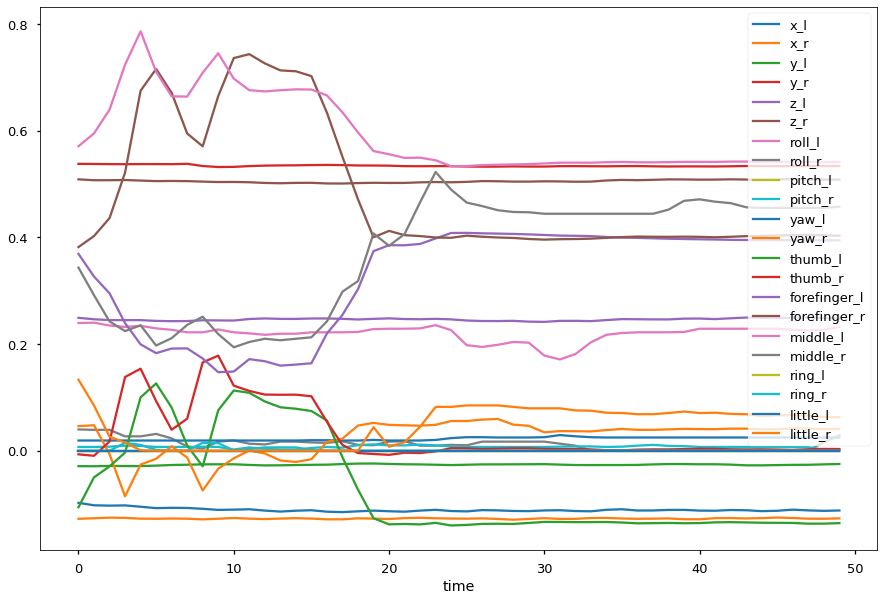

In [8]:
sign0.plot()

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

## Расчет новых признаков

Признаки мы будем считать с помощью библиотеки [tsfresh](http://tsfresh.readthedocs.io/en/latest/index.html). Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные, но при желании вы можете повторить вычисления.

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
## Если не хотите долго ждать - не убирайте комментарии
# !pip install tsfresh


# import tsfresh
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters


# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

enc = LabelEncoder()
enc.fit(sign_classes.loc[:, 'class'])
sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

# sign_features_filtered = select_features(sign_features, sign_classes.loc[:, 'target'])

# filepath = './data/tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [63]:
!mkdir ./data
!wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O ./data/tsfresh_features_filt.csv.gz
filepath = './data/tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath)

mkdir: ./data: File exists
--2021-04-07 11:02:46--  https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz [following]
--2021-04-07 11:02:47--  https://www.dropbox.com/s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdf8a4d77eb81afb64c1ff7c0df.dl.dropboxusercontent.com/cd/0/inline/BMIRsiqH02UF1p-pXpZo1alCAizohgUvQ2FHVugQryjVbx13UOI_I8f1Pj5m-lWVJ03JdDVUTFlPBWDnCIcRkJWpwn2n92g-5BldQGMEu7HewwfpmUSi4u8IHGVHlTIgR-waGBsVQkP4o1CAyGPHoFfC/file# [following]
--2021-04-07 11:02:47--  https://ucdf8a4d77eb81afb64c1ff7c0df.dl.dropboxusercontent.com/cd/0/inline/BMIRsiqH02UF1p-pXpZo1alCAizohgUvQ2FH

In [64]:
sign_features_filtered.shape

(2565, 11517)

In [65]:
sign_features_filtered.head()

,Unnamed: 0,ring_r__maximum,"ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","ring_r__fft_coefficient__attr_""abs""__coeff_2","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",ring_r__variance,ring_r__standard_deviation,...,forefinger_l__large_standard_deviation__r_0.15000000000000002,little_r__symmetry_looking__r_0.15000000000000002,z_l__symmetry_looking__r_0.35000000000000003,roll_r__large_standard_deviation__r_0.25,roll_r__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.05,pitch_l__symmetry_looking__r_0.05,z_l__large_standard_deviation__r_0.45,little_l__symmetry_looking__r_0.05,y_l__symmetry_looking__r_0.35000000000000003
0,0,0.014764,0.998626,0.000174,0.047854,0.000034,0.006166,0.000423,0.000015,0.003881,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.017579,0.017579,0.000180,0.045183,0.000027,0.003599,0.000397,0.000012,0.003399,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.043917,0.043917,0.000737,0.059952,0.000092,0.028252,0.001034,0.000142,0.011921,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,0.061037,0.061037,0.001453,0.402618,0.000127,0.047034,0.001777,0.000314,0.017728,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Базовая модель

В результате у нас получилось очень много признаков (11516 или больше), давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [15]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes.target.values

In [16]:
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [123]:
base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')
base_cv_scores.mean()

0.819493177387914

## Метод главных компонент (5 баллов)

* (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
* (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором
* (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной диспекрии можно найти в атрибуте `explained_variance_ratio`

#### 1. Настройка base_model

In [122]:
base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=20, svd_solver="randomized", random_state=123)),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

#### 2. Минимальное число n_components для score > 0.9
Для решения этой задачи можно построить для всей выборки график зависимости значения объясненённой дисперсии от количества компонент. Тогда можно будет построить график производной полученной зависимости. Тогда, если будет место резкого перелома, можно будет определить минимальное количество компонент, не перебирая все возможные количества компонент.

##### 1. График объяснённой дисперсии для максимального возможного количества компонент

In [167]:
base_model.set_params(pca__n_components = None)
base_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(random_state=123, svd_solver='randomized')),
                ('clf', KNeighborsClassifier(n_neighbors=9))])

In [174]:
variance_ratio = base_model['pca'].explained_variance_ratio_

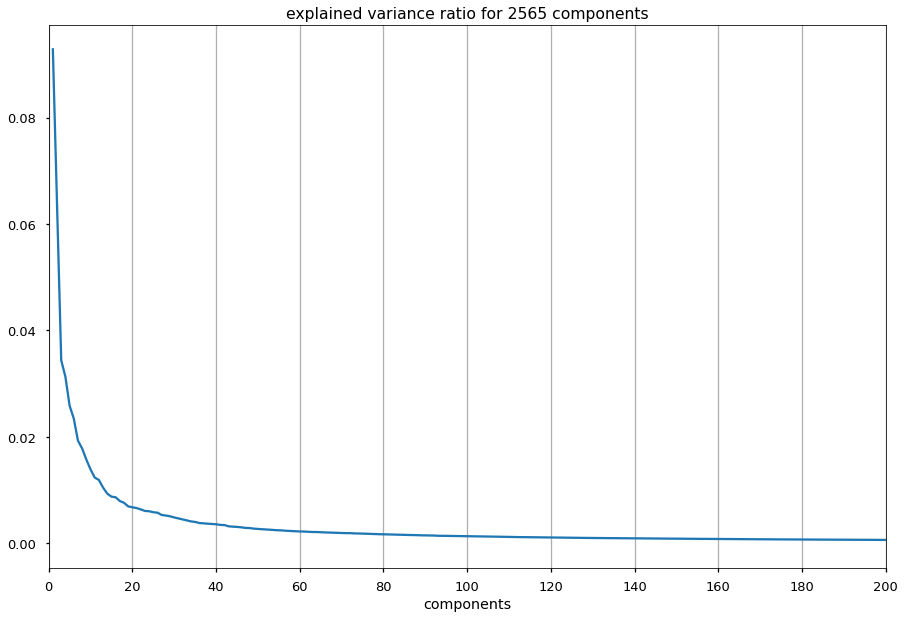

In [149]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('explained variance ratio for {} components'.format(variance_ratio.size))
ax.set_xticks(np.arange(0, variance_ratio.size + 1, 20))
ax.grid(axis='x')
ax.set_xlim((0, 200))
ax.set_xlabel("components")
ax.plot(np.arange(1, variance_ratio.size + 1), variance_ratio)

##### 2. Производная объясненной дисперсии (процентной)

In [203]:
variance_diffs = np.array(list(map(lambda x: x[1] - x[0], zip(variance_ratio[:-1], variance_ratio[1:]))))

In [204]:
variance_diffs

array([-2.88970462e-02, -2.95150289e-02, -3.09839727e-03, ...,
       -7.24464738e-08, -7.21439200e-09, -3.02194802e-06])

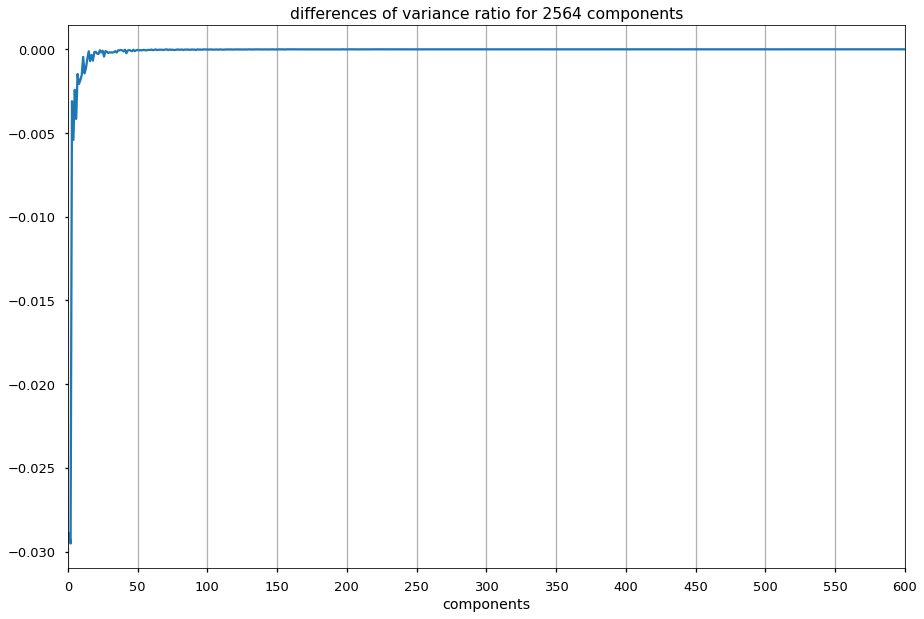

In [205]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('differences of variance ratio for {} components'.format(variance_diffs.size))
ax.set_xticks(np.arange(0, variance_diffs.size + 1, 50))
ax.grid(axis='x')
ax.set_xlim((0, 600))
ax.set_xlabel("components")
ax.plot(np.arange(1, variance_diffs.size + 1), variance_diffs)

Проверим число 50

In [195]:
# Your Code Here
base_model.set_params(pca__n_components = 50)
cv_score = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [ ]:
min(cv_score)

Качество высоко - но недостаточно по заданию. Проверим еще график накопленной дисперсии.

##### 3. График кумулятивной объяснённой дисперсии

In [175]:
variance_sums = np.cumsum(variance_ratio)

In [177]:
variance_sums

array([0.09280647, 0.15671589, 0.19111028, ..., 0.99999698, 1.        ,
       1.        ])

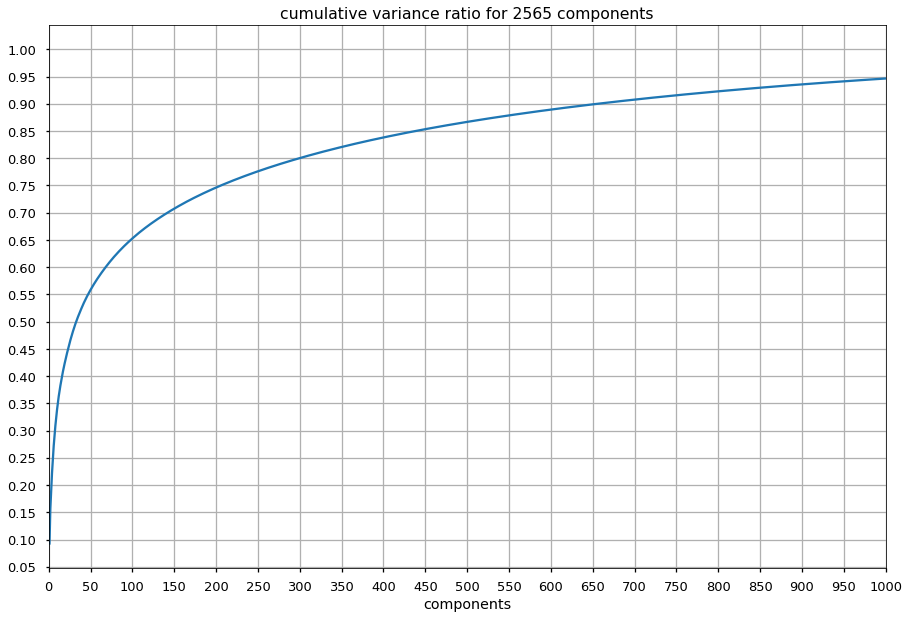

In [186]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('cumulative variance ratio for {} components'.format(variance_sums.size))
ax.set_xticks(np.arange(0, variance_sums.size + 1, 50))
ax.grid()
ax.set_xlim((0, 1000))
ax.set_xlabel("components")
ax.set_yticks(np.arange(0, 1.1, 0.05))
ax.plot(np.arange(1, variance_sums.size + 1), variance_sums)

##### 4. Решение, что делать

 По графику производной, можно было бы предположить, что 50 - неплохой стартовый вариант для перебора в целях уточнения хорошего числа компонент. По кумулятивному же графику видно, что никаких резких скачков качества после 50 уже нет. Далее можно лишь уточнять качество с помощью перебора. 
 Проверим n_components = 50

In [216]:
# Your Code Here
def score_for_components(components):
    base_model.set_params(pca__n_components = components)
    return min(cross_val_score(base_model, X, y, cv=cv, scoring='accuracy'))

In [ ]:
score_for_components(50)

Это качество недостаточно высоко.
Проверим качество для количества компонент, дающих 90 % объясснённой дисперсии (не то чтобы процент обхясненной дисперсии был прямо связан с качеством, но он всё же связан)

In [212]:
arg_90 = None
for n, var in zip(np.arange(1, variance_sums.size + 1), variance_sums):
    if (var >= 0.9):
        arg_90 = n
        break

In [213]:
arg_90

656

In [217]:
score_for_components(arg_90)

0.9005847953216374

In [224]:
base_model.set_params(pca__n_components = 200)
min(cross_val_score(base_model, X, y, cv=cv, scoring='accuracy'))

0.9083820662768031

Качество больше 0.9 достигается при 514 компонентах

#### 3. Доля объективной дисперсии

In [111]:
base_model.set_params(pca__n_components=best_n_components)
base_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 PCA(n_components=514, random_state=123,
                     svd_solver='randomized')),
                ('clf', KNeighborsClassifier(n_neighbors=9))])

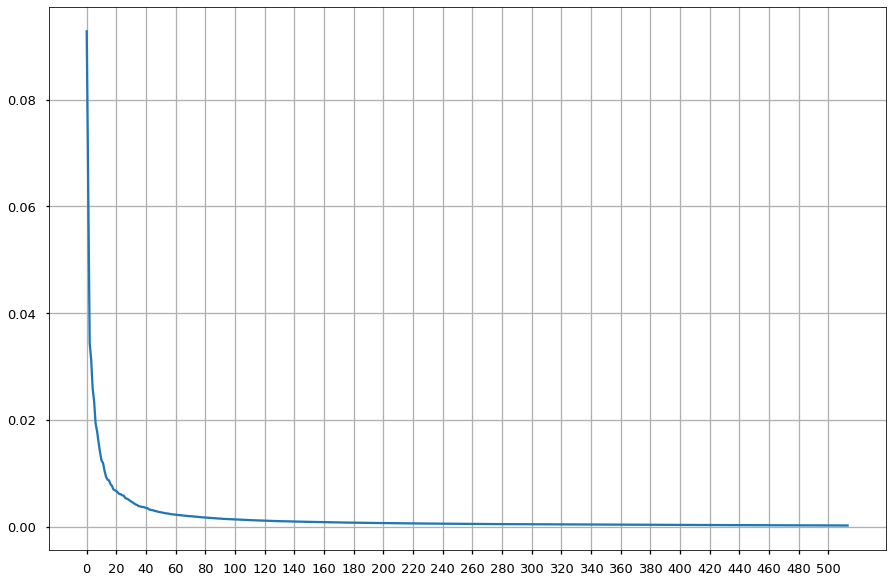

In [121]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(np.arange(0, 514, 20))
ax.grid()
ax.plot(base_model['pca'].explained_variance_ratio_)

In [118]:
base_model['pca'].explained_variance_ratio_[best_n_components - 1]

0.00021597254413225847

# Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:
* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано 
* его рубрика 

In [225]:
df = pd.read_csv('../data/news.csv', encoding='utf8')
df.head()

,text,date,event,class
0,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,"Google Новости ТОП, Москва, 14 января 2017 АК...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ


In [226]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Внутренняя политика: культура                    100
Проишествия  РФ                                  100
Спорт                                            100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубликами с помощью ARI

## Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [227]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [228]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [231]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/algor/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [232]:
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)   

In [233]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2021-04-07 17:37:28--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.245, 5.45.205.244, 5.45.205.241, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.245|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-ektmts01.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-04-07 17:37:28--  http://cache-ektmts01.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-ektmts01.cdn.yandex.net (cache-ektmts01.cdn.yandex.net)... 5.45.240.10
Connecting to cache-ektmts01.cdn.yandex.net (cache-ektmts01.cdn.yandex.net)|5.45.240.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linux3.1 100%[===================>]  15,70M  15,6MB/s

In [234]:
%%time 
from pymystem3 import Mystem


# нормализуем текст
m = Mystem('/root/.local/bin/mystem')
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 659 ms, sys: 3.72 s, total: 4.37 s
Wall time: 6.81 s


In [236]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Еще кое-что удаляем
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

In [237]:
df.text[0] # так выгладит первая статья после предобработки

''

## Вычисление сходства (1 балл)

С помощью `TfidfVectorizer` и `pairwise_distances` расчитайте **косинусное** расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью `CountVectorizer` или `TfidfVectorizer` можно почитать [тут](https://www.machinelearningmastery.ru/gentle-introduction-bag-words-model/) 

Запишите результат в переменную `S`

In [238]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [240]:
vect = TfidfVectorizer()
texts = df.text.values

In [ ]:
# Your Code Here

In [ ]:
S = ...

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])


Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль диагонали матрицы попарых расстояний есть "блоки" по похожести. 

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

## DBSCAN (4 балла)
* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Не копипастите `min_pts = 2` из семинара! Используйте **косинусную** меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index)

In [ ]:
# Your Code Here

In [ ]:
labels = ...

In [ ]:
pd.crosstab(df.loc[:, 'class'], labels)

In [ ]:
adjusted_rand_score(true_label, labels)